# Waste classification

Sources: 

https://medium.com/geekculture/classifying-waste-images-with-machine-learning-14b249f11544


https://www.kaggle.com/code/beyzanks/waste-classification-with-cnn

## 1. Importing libraries and extracting dataset

In [ ]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import tensorflow
import keras 
import zipfile as zf

import warnings
warnings.filterwarnings('ignore')
import os
for dirname, _, _ in os.walk('/kaggle/input'):
        print(dirname)

In [ ]:
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.utils import img_to_array 
from keras.utils.vis_utils import plot_model
from glob import glob
from keras.preprocessing.image import ImageDataGenerator

### Uploading dataset manually

In [ ]:
!wget https://storage.googleapis.com/final_amt/archive.zip

--2023-01-09 11:11:52--  https://storage.googleapis.com/final_amt/archive.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.16.128, 172.253.62.128, 172.253.115.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.16.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447914276 (427M) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>] 427.16M   229MB/s    in 1.9s    

2023-01-09 11:11:54 (229 MB/s) - ‘archive.zip’ saved [447914276/447914276]



In [ ]:
dataset = zf.ZipFile(f'archive.zip', 'r')
dataset.extractall()
dataset.close()

## 2. Visualisation

In [ ]:
train_path = "/content/DATASET/TRAIN"
test_path = "/content/DATASET/TEST"

In [ ]:
x_data = [] 
y_data = [] 

for category in glob(train_path+'/*'):
    for file in tqdm(glob(category+'/*')):
        img_array=cv2.imread(file)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        x_data.append(img_array) 
        y_data.append(category.split("/")[-1])
        
data=pd.DataFrame({'image': x_data,'label': y_data})

In [ ]:
data.shape

In [ ]:
from collections import Counter
Counter(y_data)

In [ ]:
colors = ['#a0d157','#c48bb8']
plt.pie(data.label.value_counts(),startangle=90,explode=[0.05,0.05],autopct='%0.2f%%',
        labels=['Organic', 'Recyclable'], colors= colors,radius=2)
plt.show()

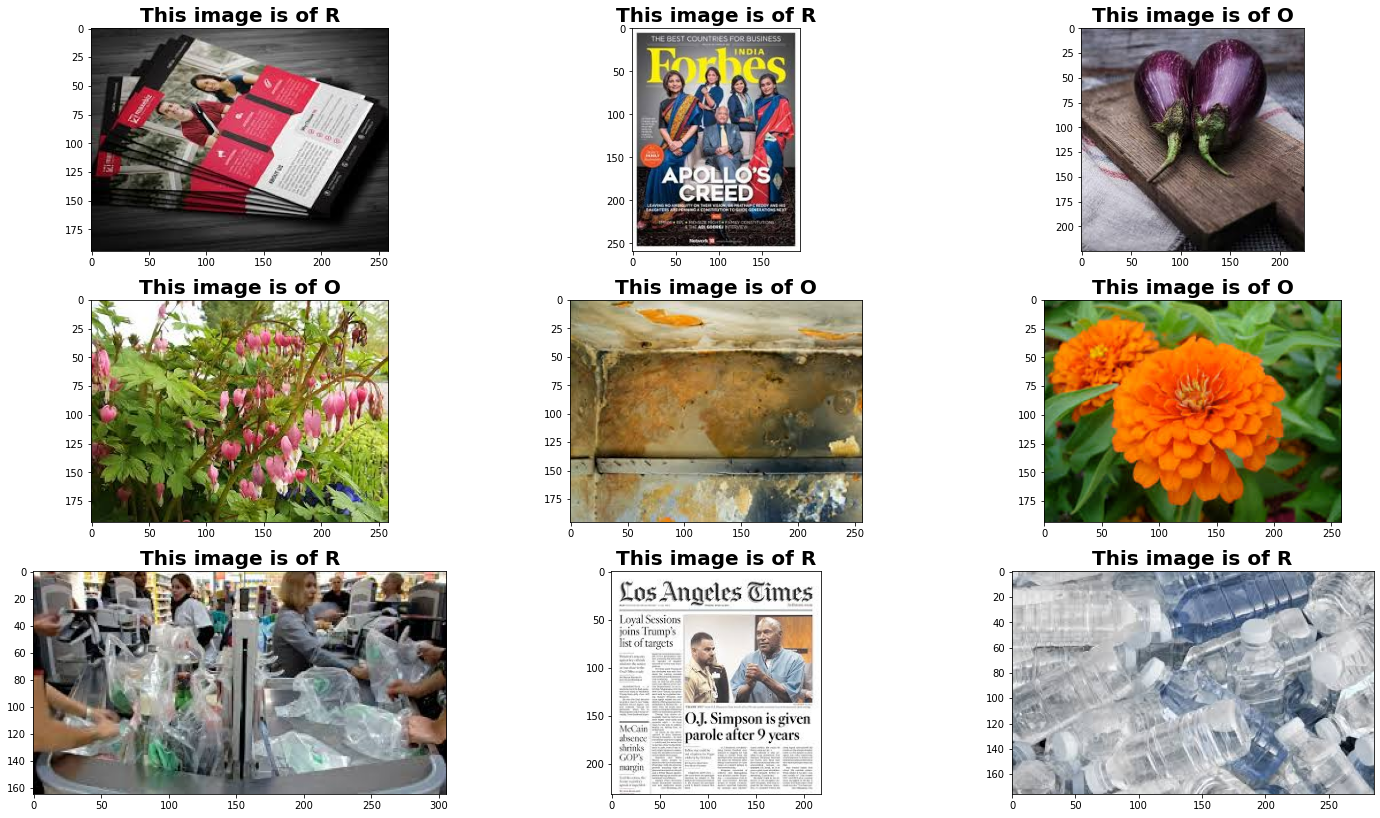

In [ ]:
plt.figure(figsize=(20,15))
for i in range(9):
    plt.subplot(4,3,(i%12)+1)
    index=np.random.randint(15000)
    plt.title('This image is of {0}'.format(data.label[index]),fontdict={'size':20,'weight':'bold'})
    plt.imshow(data.image[index])
    plt.tight_layout()

O -> Organic
R -> Recyclable

In [ ]:
className = glob(train_path + '/*' )
numberOfClass = len(className)
print("Number Of Class: ",numberOfClass)

Number Of Class:  2


## 3. Convolutional Neural Network - CNN

In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (224,224,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))  
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("sigmoid"))

model.compile(loss = "binary_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

batch_size = 256

In [ ]:
plot_model(model)

In [ ]:
train_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
test_datagen = ImageDataGenerator(rescale= 1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

test_generator = test_datagen.flow_from_directory(
        test_path, 
        target_size= (224,224),
        batch_size = batch_size,
        color_mode= "rgb",
        class_mode= "categorical")

In [ ]:
hist = model.fit_generator(
        generator = train_generator,
        epochs=10,
        validation_data = test_generator)

In [ ]:
plt.figure(figsize=[10,6])
plt.plot(hist.history["accuracy"], label = "Train acc")
plt.plot(hist.history["val_accuracy"], label = "Validation acc")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], label = "Train loss")
plt.plot(hist.history['val_loss'], label = "Validation loss")
plt.legend()
plt.show()

## 4. Model Prediction

In [ ]:
def predict_func(img): 
    plt.figure(figsize=(6,4))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.tight_layout()
    img = cv2.resize(img, (224, 224))
    img = np.reshape(img, [-1, 224, 224,3])
    result = np.argmax(model.predict(img))
    if result == 0: print("\033[94m"+"This image -> Recyclable"+"\033[0m")
    elif result ==1: print("\033[94m"+"This image -> Organic"+"\033[0m")

## 5. Testing out model

### 5.1 Organic

In [ ]:
test_img = cv2.imread("/content/dataset/DATASET/TEST/O/O_13255.jpg")
predict_func(test_img)

### 5.2 Recyclable 

In [ ]:
test_img = cv2.imread("/content/dataset/DATASET/TEST/R/R_10098.jpg")
predict_func(test_img)